In [1]:
pip install xgboost lightgbm catboost optuna 

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [16]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, LGBMRegressor 
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep10/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep10/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep10/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

In [4]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']

test_baseline = test.drop(columns = ['id'], axis = 1)

GBC_md = GradientBoostingClassifier(n_estimators = 500, 
                                    max_depth = 3, 
                                    learning_rate = 0.01,
                                    min_samples_split = 2,
                                    min_samples_leaf = 2).fit(X, Y)

GBC_pred = GBC_md.predict_proba(test_baseline)[:, 1]
submission['Class'] = GBC_pred
submission.head()

,id,Class
0,117564,0.002229
1,117565,0.002533
2,117566,0.002229
3,117567,0.023682
4,117568,0.005867


In [17]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']

test_baseline = test.drop(columns = ['id'], axis = 1)

GBC_md = GradientBoostingClassifier(n_estimators = 1000, 
                                    max_depth = 3, 
                                    learning_rate = 0.01,
                                    min_samples_split = 2,
                                    min_samples_leaf = 2).fit(X, Y)

lgb_md = LGBMClassifier(n_estimators = 1000,
                        max_depth = 3,
                        learning_rate = 0.01,
                        num_leaves = 20,
                        lambda_l1 = 3,
                        lambda_l2 = 3,
                        bagging_fraction = 0.7,
                        feature_fraction = 0.7).fit(X, Y)

xgb_md = XGBClassifier(tree_method = 'hist',
                       colsample_bytree = 0.7, 
                       gamma = 0.8, 
                       learning_rate = 0.01, 
                       max_depth = 7, 
                       min_child_weight = 10, 
                       n_estimators = 1000, 
                       subsample = 0.7).fit(X, Y)

cat_md = CatBoostClassifier(loss_function = 'Logloss',
                            iterations = 1000,
                            learning_rate = 0.01,
                            depth = 7,
                            random_strength = 0.5,
                            bagging_temperature = 0.7,
                            border_count = 30,
                            l2_leaf_reg = 5,
                            verbose = False, 
                            task_type = 'CPU').fit(X, Y)

GBC_pred = GBC_md.predict_proba(test_baseline)[:, 1]
lgb_pred = lgb_md.predict_proba(test_baseline)[:, 1]
xgb_pred = xgb_md.predict_proba(test_baseline)[:, 1]
cat_pred = cat_md.predict_proba(test_baseline)[:, 1]

ens_preds = 0.01*GBC_pred + 0.34*lgb_pred + 0.3*xgb_pred + 0.35*cat_pred
submission['Class'] = ens_preds
submission.head()

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


,id,Class
0,117564,0.000164
1,117565,0.001277
2,117566,0.000268
3,117567,0.080343
4,117568,0.002529


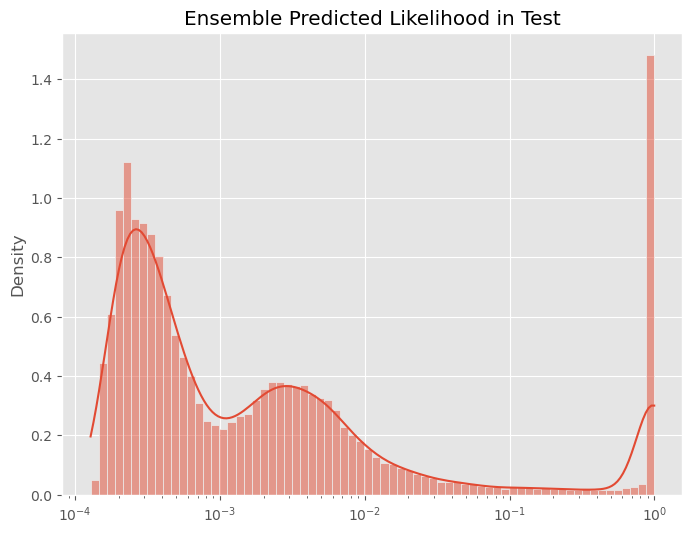

In [18]:
plt.figure(figsize = (8, 6))
sns.histplot(data = ens_preds, kde = True, stat = 'density', log_scale = True).set(title = 'Ensemble Predicted Likelihood in Test');

In [19]:
submission.to_csv('Ensemble_Baseline_full_submission_5.csv', index = False)